### Importing Important Modules 

In [1]:
#Enabling interactive secession for the notebook and save in very 20 second.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
%autosave 20

Autosaving every 20 seconds


In [2]:
from __future__ import print_function
import torch                                #Importing Torch module as ml framework desined for reserchers and developer.
import torch.nn as nn                       #NN module have classes and modules to implement and train the neural network.
import torch.nn.functional as F             #Functional provides module like activations,losses etc
import torch.optim as optim                 #Importing optimizer moduke from torch
from torchvision import datasets, transforms#Importing Torch vision for datasets and data transforms.

/home/jd/miniconda3/envs/eva/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
import matplotlib.pyplot as plt

In [15]:
from kernel_viz import print_layer

In [16]:
#importing a module created by me to calculate receptive field.Having copule of bugs but works fine.
from  rf_calc import receptive_field

In [5]:
torch.__version__ #checking Troch version

'1.13.0'

In [6]:
#Checking for torch GPU support
print(f"Is cuda GPU avalable: {torch.cuda.is_available()}")

Is cuda GPU avalable: True


In [7]:
use_cuda = torch.cuda.is_available() #chjecking if cuda is available or not
device = torch.device("cuda" if use_cuda else "cpu") #if gpu is available then device = cuda else cpu
torch.manual_seed(1)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [8]:
### Defining train loader and test loader 

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,  #downloading the data at /data folder,its for trainning
                    transform=transforms.Compose([       #data transformation includes converting to tensor and normalizing with the mean and std of the dataset
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

### Trainning Function

from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()   #model set to trainning
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar): # Iterating through data and target
        data, target = data.to(device), target.to(device)  #pushing data and target to gpu
        optimizer.zero_grad() # making all the gradients to zero
        output,x1,x2,x3,x4,x5 = model(data) # predicting op
        type(output)
        loss = F.nll_loss(output, target) # calculating loss
        loss.backward()  # This is backpropagation in action.
        optimizer.step() # Updating old weights with new 
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')

### Testing Function

def test(model, device, test_loader):
    model.eval()  #Model set to evaluation mode.
    test_loss = 0  
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output,x1,x2,x3,x4,x5 = model(data)   #predicting the test data
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

###  Model Class defination

In [9]:
class Net(nn.Module):       #created a model class as Net  inhereate properties from nn.Modules
    def __init__(self,x_times = 1):     #defining Init function.
        super(Net, self).__init__()
        x_times = x_times
        self.conv1 = nn.Conv2d(1,8, 3, padding=1)    #input:28*28  OUtput:28*28 RF:3*3   (RF Considering MaxPooling doubles the RF for now)
        self.conv2 = nn.Conv2d(8, 8, 3, padding=1)   #input:28*28  OUtput:28*28 RF:5*5
        self.pool1 = nn.MaxPool2d(2, 2)                #input:28*28  OUtput:14*14 RF:10*10
        self.conv3 = nn.Conv2d(8, 16, 3, padding=1)  #input:14*14  OUtput:14*14 RF:12*12
        self.conv4 = nn.Conv2d(16, 16, 3, padding=1) #input:14*14  OUtput:14*14 RF:14*14
        self.pool2 = nn.MaxPool2d(2, 2)                #input:14*14  OUtput:7*7 RF:28*28
        self.conv5 = nn.Conv2d(16, 32, 3)            #input:7*7    OUtput:5*5 RF:30*30
        self.conv6 = nn.Conv2d(32, 64, 3)           #input:5*5    OUtput:3*3 RF:32*32
        self.conv7 = nn.Conv2d(64, 10, 3)            #input:3*3    OUtput:1*1 RF:34*34
        
    def forward(self, x):  #forward functions
        x1 = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x))))) #maxpool--> relu-->conv2-->relu-->conv1
        x2 = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x1))))) #maxpool--> relu-->conv4-->relu-->conv3
        x3 = F.relu(self.conv6(F.relu(self.conv5(x2))))             #relu-->conv6-->relu-->conv5
        x4 = self.conv7(x3)                                         #conv7
        x5 = x4.view(-1, 10)                                        #Changing dimention of data.
        return F.log_softmax(x5,-1),x1,x2,x3,x4,x5                           #Final log softmax layer 

In [10]:
class Net1(nn.Module):       #created a model class as Net  inhereate properties from nn.Modules
    def __init__(self):     #defining Init function.
        super(Net1, self).__init__()
        self.conv = nn.Conv2d( in_channels=1,out_channels=1,kernel_size=(3,3),stride=1,padding= 1, bias=False, padding_mode = 'replicate')
    
    def forward(self, x):  #forward functions
        x = self.conv(x)
        return x                          #Final log softmax layer 

In [11]:
from torchsummary import summary   #importing torchsummary.
model = Net1().to(device) #creating model and sending it to "CPU/CUDA"
summary(model, input_size=(1, 28, 28))  #Printing the model summary details 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 1, 28, 28]               9
Total params: 9
Trainable params: 9
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [12]:
for batch_idx, (data, target) in enumerate(train_loader): # Iterating through data and target
    data, target = data.to(device), target.to(device)  #pushing data and target to gpu
    break

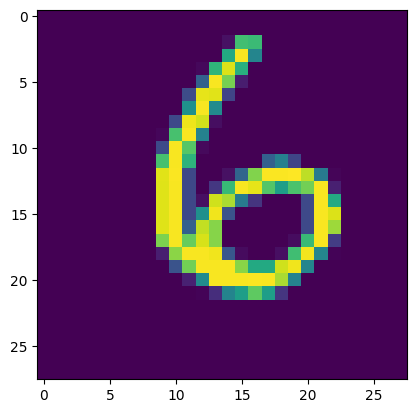

In [17]:
_ = plt.imshow(data[0].reshape(28,28,-1).to('cpu'))

In [18]:
x = model(data[0])

In [23]:
data[0].shape

torch.Size([1, 28, 28])

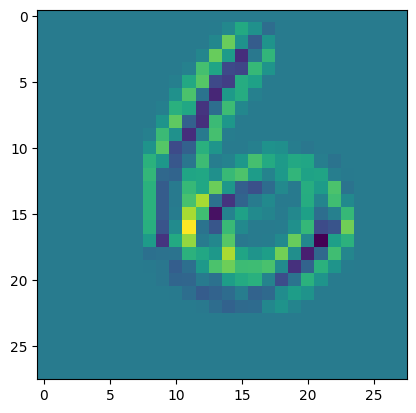

In [27]:
plt.imshow(x.to('cpu').reshape(28,28,-1).detach().numpy() )

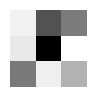

In [28]:
print_layer(model.conv.weight.detach().clone())

### Let's calculate the Receptive field

In [ ]:
rf_df = receptive_field(model_obj=model,input_image=28)

In [ ]:
i = 1
print (f"Model Reduced the parameter {i} times the base model")
model = Net(x_times = i).to(device) #creating model and sending it to "CPU/CUDA"
summary(model, input_size=(1, 28, 28))  #Printing the model summary details 
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9) # setting the optimizer

for epoch in range(1, 2):    # running is for 1 epoch
    train(model, device, train_loader, optimizer, epoch)  # Running the Train Function
    test(model, device, test_loader)    # running the test Function

### Let's Take one image and send it to conv and see what's happening 

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
for batch_idx, (data, target) in enumerate(train_loader): # Iterating through data and target
    data, target = data.to(device), target.to(device)  #pushing data and target to gpu
    break

In [ ]:
_ = plt.imshow(data[0].reshape(28,28,-1).to('cpu'))

In [ ]:
target[0]

In [ ]:
output_val,x1,x2,x3,x4,x5 = model(data[0])

In [ ]:
output_val

In [ ]:
x1.shape
x2.shape
x3.shape
x4.shape
x5.shape

In [ ]:
x5

### Difference between with relu and without relu

##### With Relu

In [ ]:
F.relu(x5)

In [ ]:
F.log_softmax(F.relu(x5),-1)  #Because Relu set the last layer's negative information to zero, the majority of values are identical.

In [ ]:
F.log_softmax(F.relu(x5),-1).squeeze()

In [ ]:
#loss
l = F.nll_loss(F.log_softmax(F.relu(x5),-1).squeeze() , target[0])

In [ ]:
l

##### Without Relu

In [ ]:
x5

In [ ]:
F.log_softmax(x5,-1)  #Because Relu set the last layer's negative information to zero, the majority of values are identical.

In [ ]:
F.log_softmax(x5,-1).squeeze()

In [ ]:
#loss
F.nll_loss(F.log_softmax(x5,-1).squeeze() , target[0])

### Let's Visualize some kernels we trainned

In [ ]:
print_layer(model.conv7.weight.detach().clone())

In [ ]:
print_layer(model.conv6.weight.detach().clone())

In [ ]:
print_layer(model.conv5.weight.detach().clone())

In [ ]:
print_layer(model.conv4.weight.detach().clone())

In [ ]:
print_layer(model.conv3.weight.detach().clone())

In [ ]:
print_layer(model.conv2.weight.detach().clone())

In [ ]:
print_layer(model.conv1.weight.detach().clone())